In [3]:
import os
from pathlib import Path

import pandas as pd

import dask
from dask import dataframe as dd
from dask import array as da
from dask_sql import Context

data_path = Path(os.getcwd()).parent/"data"

# Distributed Cluster 

Dask distributed client have problems with single machine run  
Fix: upgrade msgpack-python == 1.0.5  
https://github.com/dask/distributed/issues/8038  

 
reference for LocalCluster configuration : 
- https://stackoverflow.com/questions/57760475/difference-between-dask-distributed-localcluster-with-threads-vs-processes
- https://stackoverflow.com/questions/55784232/right-way-to-set-memory-parameters-for-localcluster-in-dask

**Parameter**  

n_workers=4 : Number of workers (Dask show _processes_ ), worker memory after allocated to core service (2G) will be distribued equally among each workers if Local machine have memory 16MB, for 4 workers each have 16 - 2 = 14 / 4 ~ 3.5G per worker.  

threads_per_worker= # machine cores / # worker

memory_limit=machine memory / # n_workers : possible to set beyond the machine limit. 

**reference from Dask API**
- https://distributed.dask.org/en/stable/worker-memory.html#thresholds-configuration

distributed:  
  worker:  
   Fractions of worker process memory at which we take action to avoid memory  
   blowup. Set any of the values to False to turn off the behavior entirely.  
    memory:  
      target: 0.60     # fraction of managed memory where we start spilling to disk  
      spill: 0.70      # fraction of process memory where we start spilling to disk  
      pause: 0.80      # fraction of process memory at which we pause worker threads  
      terminate: 0.95  # fraction of process memory at which we terminate the worker

In [4]:
from dask.distributed import LocalCluster, Client

dask.config.set({ "distributed.worker.memory.target": 0.6, 
                 "distributed.worker.memory.spill": 0.7, 
                 "distributed.worker.memory.pause": 0.8, 
                 "distributed.worker.memory.terminate": 0.95}) 

client = LocalCluster(n_workers=4).get_client()

/home/danny/miniconda3/envs/dask/lib/python3.12/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 44345 instead
  warnings.warn(


In [5]:
print(client)

<Client: 'tcp://127.0.0.1:36953' processes=4 threads=4, memory=15.02 GiB>


In [6]:
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:44345/status,
Dashboard: http://127.0.0.1:44345/status,Workers: 4
Total threads: 4,Total memory: 15.02 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:36953,Workers: 4
Dashboard: http://127.0.0.1:44345/status,Total threads: 4
Started: Just now,Total memory: 15.02 GiB
Comm: tcp://127.0.0.1:43487,Total threads: 1
Dashboard: http://127.0.0.1:39605/status,Memory: 3.75 GiB
Nanny: tcp://127.0.0.1:45131,


In [7]:
client.dashboard_link

'http://127.0.0.1:44345/status'

In [8]:
parquet_path = data_path/"combined_wp_w_div.parquet"

read_ddf = dd.read_parquet(parquet_path)
print(f"Division know : {read_ddf.known_divisions}, number of partition : {read_ddf.npartitions}")

Division know : False, number of partition : 89


In [9]:
read_ddf.dtypes

User                       int16
Card                       int16
Month                      int16
Day                        int16
Time              string[python]
Amount            string[python]
Use Chip          string[python]
Merchant Name     string[python]
Merchant City     string[python]
Merchant State    string[python]
Zip                      float64
MCC                        int16
Errors?           string[python]
Is Fraud?         string[python]
amount                   float64
Year                    category
dtype: object

In [22]:
# Code to test the performance of the dask dataframe
summ = read_ddf.assign(dummy_sum = lambda x: x["User"] + x["Card"] + x["Month"] + x["Day"] + x["Zip"] + x["MCC"] + x["amount"])

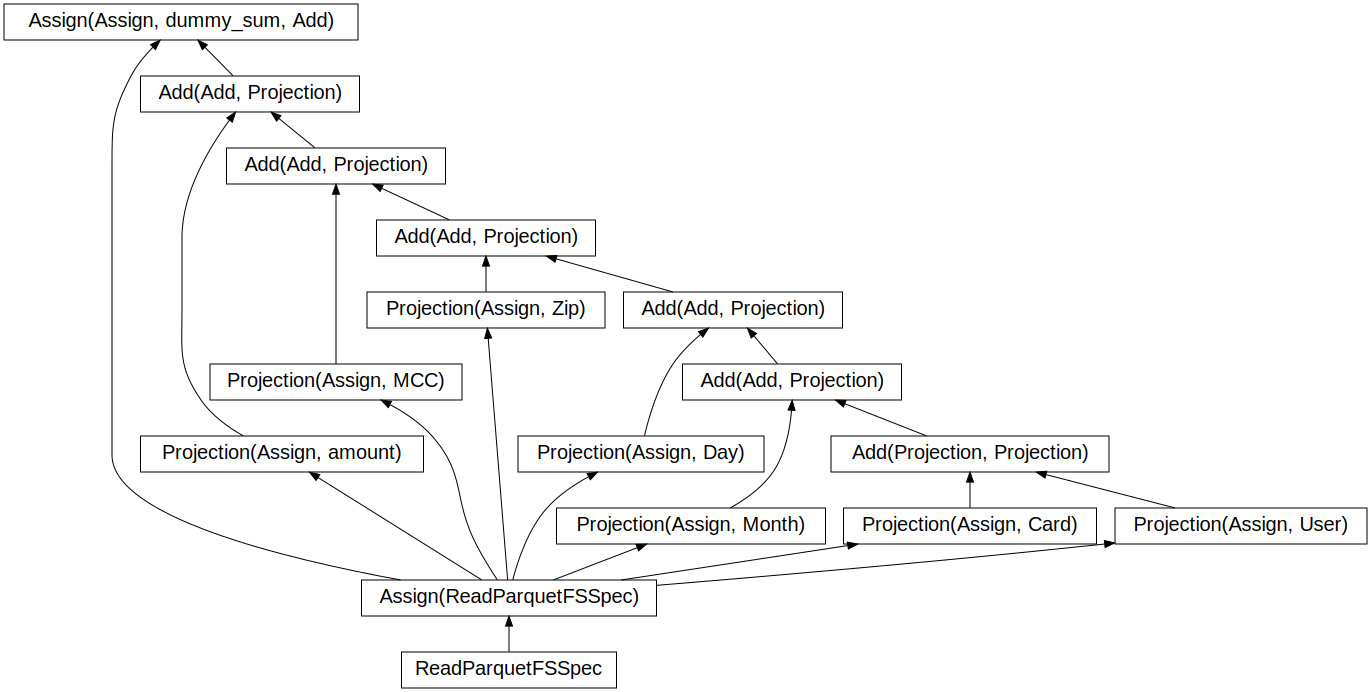

In [23]:
summ.visualize()

Use `client.compute( xxx )` to submit dask graph to cluster & return `Future` object  
The `Future` is the submitted to cluster task with async (no wait for the command to success)

In [24]:
total = client.compute(summ.groupby("Year").agg(tt_dummy = ("dummy_sum", "sum")))

/home/danny/miniconda3/envs/dask/lib/python3.12/site-packages/dask_expr/_groupby.py:1542: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  self._meta = self.obj._meta.groupby(


Future object show pending, till the ask finished.

In [26]:
total

<Future: finished, type: pandas.core.frame.DataFrame, key: finalize-3fa6c09b27145377001bd71ae6fce4b6>

To get the result to local, use Future.result()

In [27]:
total.result()

,tt_dummy
Year,
1991,5.569687e+07
1992,3.504451e+08
1993,6.035396e+08
1994,9.217667e+08
1995,1.258207e+09
1996,1.803374e+09
1997,2.891529e+09
1998,4.390289e+09
1999,6.567229e+09


In [28]:
yr_cnt = client.compute(read_ddf.groupby("Year").agg({"User":"count"}))
yr_cnt

/home/danny/miniconda3/envs/dask/lib/python3.12/site-packages/dask_expr/_groupby.py:1542: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  self._meta = self.obj._meta.groupby(


<Future: pending, key: finalize-fec48c20c3a76be5b3f94108607603bb>

In [29]:
yr_cnt.result()

,User
Year,
1991,1585
1992,5134
1993,8378
1994,14316
1995,20928
1996,29945
1997,49753
1998,78345
1999,118250
